# Import des modules

In [401]:
import nltk
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import wordcloud
import sklearn
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

# Chargement des données
![South Park](https://upload.wikimedia.org/wikipedia/en/4/41/South_Park_main_characters.png)

In [402]:
# Jeu de données récupéré sur kaggle : https://www.kaggle.com/tovarischsukhov/southparklines
df = pd.read_csv("southpark.csv")

# Explorons le dataset

----
Si vous ne connaissez pas pandas c'est le moment de prendre 10min pour vous former : https://pandas.pydata.org/docs/user_guide/10min.html

----
Cartman parle beaucoup il occupe la parole x% du temps : quel est cette proportion?

In [403]:
df.head()

,Season,Episode,Character,Line
0,10,1,Stan,"You guys, you guys! Chef is going away. \n"
1,10,1,Kyle,Going away? For how long?\n
2,10,1,Stan,Forever.\n
3,10,1,Chef,I'm sorry boys.\n
4,10,1,Stan,"Chef said he's been bored, so he joining a gro..."


In [404]:
# Quels sont les personnages les plus présents ?
df["Character"].value_counts().head(10)

Cartman         9774
Stan            7680
Kyle            7099
Butters         2602
Randy           2467
Mr. Garrison    1002
Chef             917
Kenny            881
Sharon           862
Mr. Mackey       633
Name: Character, dtype: int64

Cartman est prend la paole 14% du temps.

In [405]:
round((df["Character"].value_counts().head(10) / len(df))[0], 2)

0.14

In [406]:
df.describe()

,Season,Episode,Character,Line
count,70896,70896,70896,70896
unique,19,19,3950,64301
top,2,10,Cartman,What?\n
freq,6416,5271,9774,361


# Cartman or Not Cartman

![South Park](https://cdn.radiofrance.fr/s3/cruiser-production/2019/09/31a9cba2-d57f-4172-9ff1-93a0fe505e75/801x410_eric_cartman_south_park.jpg)

On voit que Cartman est le personnage le plus présent dans le dataset, il prend la paole 14% du temps.

On va préparer le jeu de données pour résoudre le problème suivant :
Pour chaque phrase du jeu de donnée on veut vouloir prédire si elle a été prononcée par Cartman ou par quelqu'un d'autre

Pour commencer on va ajouter la colonne "is_cartman" au dataframe df : elle doit être à 1 si c'est cartman qui a prononcé la phrase, 0 si ce n'est pas lui

In [407]:
df["is_cartman"] = df["Character"] == "Cartman" # df.apply(lambda f: f["Character"] == "Cartman" if 1 else 0, axis=1)

On va équilibrer le problème, on veut conserver autant de is_cartman à 0 qu'à 1.

In [408]:
nb_cartman = len(df.query("is_cartman == 1")) # len(df[df["is_cartman"] == 1])
nb_cartman

9774

In [409]:
df = pd.concat([df[df["is_cartman"] == 0].sample(nb_cartman), df[df["is_cartman"] == 1]]).sample(frac=1).reset_index(drop=True)

In [410]:
# Si ça passe ça doit être bon
assert len(df.query("is_cartman == 1")) == len(df.query("is_cartman == 0"))
assert len(df.query("is_cartman == 1")) == nb_cartman

Conservons uniquement les colonnes qui vont nous intéresser : Line et is_cartman

In [411]:
df = df[["Line", "is_cartman"]]

In [412]:
# Si ça passe ça doit être bon
assert (df.columns == ["Line", "is_cartman"]).all()

On va splitter aléatoirement le dataframe en 2, un dataframe pour l'entrainement du modèle et un autre pour la validation.

On veut 50% des données pour l'entrainement et 50% pour la validation et on les appelle df_train et df_valid

In [413]:
df_train, df_valid = train_test_split(df, test_size=0.5, random_state=1)
print(len(df_train), str(len(df_train) * 100 / len(df)) + "%")
print(len(df_valid), str(len(df_valid) * 100 / len(df)) + "%")

df_train = df_train.copy()

9774 50.0%
9774 50.0%


In [414]:
assert len(df_train) == len(df_valid), "train et valid n'ont pas la même taille"
assert len(df_train) == len(df) / 2, "df doit être 2x plus grand que train"

On va oublier un temps df_valid et se concentrer uniquement à la préparation des données sur df_train

# Text preprocessing

faites une fonction extract_tokens qui pour extraire les tokens d'un texte :
    - nltk est l'outil parfait pour vous aider (https://www.nltk.org/)
    - les textes sont en anglais, veuillez à bien utiliser les fonctions en english

In [415]:
# nécessaire la 1er fois
nltk.download("punkt")
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/charles/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/charles/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [416]:
text = "This is a sample text. Use it to test your function!"

In [417]:
def extract_tokens(text):
    return nltk.word_tokenize(text)

In [418]:
# Si ça passe c'est bon
assert (extract_tokens(text) == ["This", "is", "a", "sample", "text", ".", "Use", "it", "to", "test", "your", "function", "!"]), "nope"

Nettoyez le texte en créant la fonction clean_tokens: supprimez la ponctuation et mettez tout en minuscule

In [419]:
def clean_tokens(tokens):
    sw = stopwords.words('english')
    return [token.lower() for token in tokens if token.isalpha()] # if token not in string.punctuation

In [420]:
# Si ça passe c'est bon
assert (clean_tokens(extract_tokens(text)) == ["this", "is", "a", "sample", "text", "use", "it", "to", "test", "your", "function"]), "nope"

Ajoutez la colonne tokens à votre dataframe d'entrainment

In [421]:
df_train["tokens"] = [clean_tokens(extract_tokens(line)) for line in df_train["Line"]]
# df_train["tokens"] = df_train["Line"].apply(lambda line: clean_tokens(extract_tokens(line)))

In [422]:
# Si ça passe ça doit être bon
assert (df_train.columns == ["Line", "is_cartman", "tokens"]).all()

# Visualisons les mots

On va générer des wordcloud représentant la fréquence des mots dans notre dataset

On va pour cela compter tous les mots puis les afficher avec le package wordcloud : http://amueller.github.io/word_cloud/

Comptons tous les mots et créons le dictionnaire word_freq = {"mot": nb_occurence_mot}

In [423]:
word_freq = pd.Series(np.concatenate([tokens for tokens in df_train["tokens"]])).value_counts()

on peut utiliser maintenant utiliser : http://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html#wordcloud.WordCloud.generate_from_frequencies

In [424]:
def displayWordCloud(word_freq) :
    wc = wordcloud.WordCloud(width=800, height=600).generate_from_frequencies(word_freq)
    plt.figure(figsize=(15, 10))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

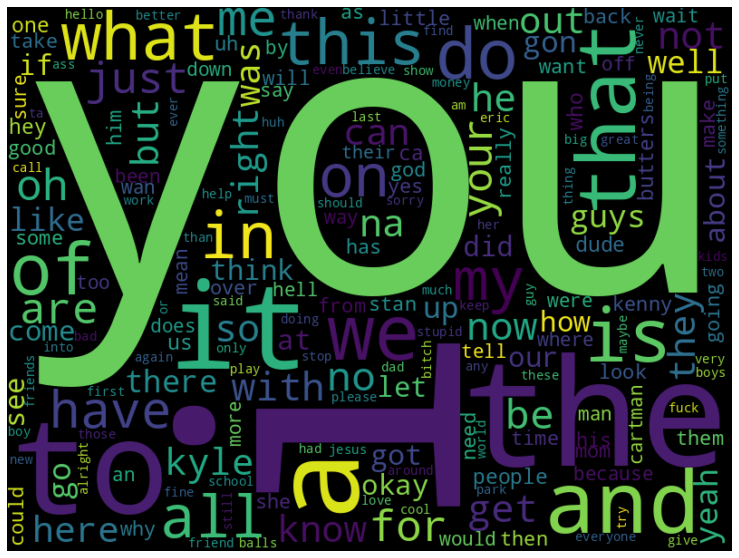

In [425]:
displayWordCloud(word_freq)

In [427]:
def clean_stopwords_tokens(tokens):
    sw = stopwords.words('english')
    return [token for token in tokens if token not in sw]
df_train["tokens"] = df_train["tokens"].apply(clean_stopwords_tokens)

Reproduisez la même chose sur les sous ensembles is_cartman == 0 et is_cartman == 1

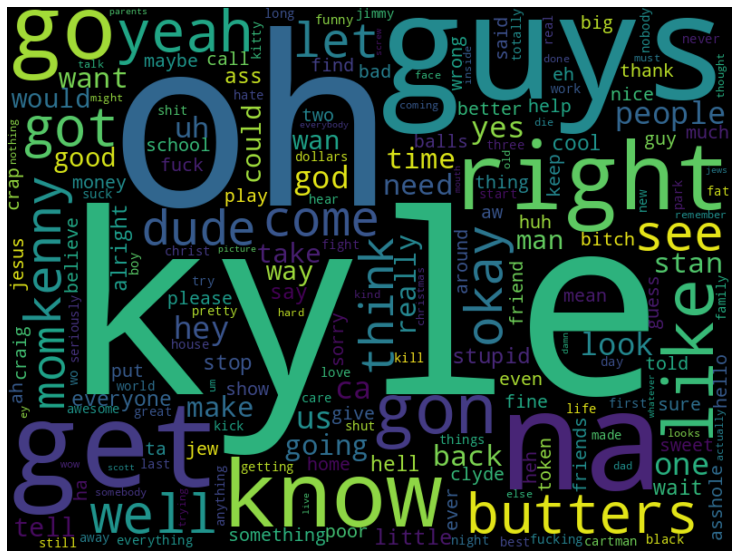

In [428]:
df_trainCart = df_train[df_train["is_cartman"] == 1]
word_freq = pd.Series(np.concatenate([tokens for tokens in df_trainCart["tokens"]])).value_counts()
displayWordCloud(word_freq)

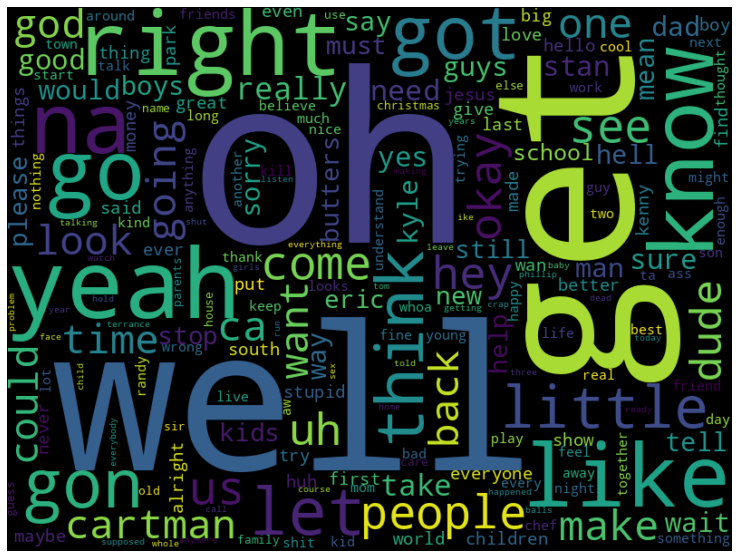

In [429]:
df_trainNotCart = df_train[df_train["is_cartman"] == 0]
word_freq = pd.Series(np.concatenate([tokens for tokens in df_trainNotCart["tokens"]])).value_counts()
displayWordCloud(word_freq)

Qu'est-ce que vous observez?
Qu'a t'on oublié?
Appliquez le correctif sur les données et affichez à nouveau les wordclouds

# Bag of words

Le texte est maintenant nettoyé, on va le transformer en features en prenant le modèle basique du "bag of words".

Vous allez construire tout d'abord le dictionnaire complet des mots du corpus, et associer à chaque mot un id entre 0 et nb_words.
Cet id correspondra à la position du mot dans le vecteur des features

In [ ]:
words_to_id = dict()

Pour chaque réplique vous allez compter le nombre d'occurences de chaque mot et générer le vecteur des features en utilisant le dictionnaire que vous venez de générer

In [ ]:
def bag_of_words_to_vector(bag_of_words, words_to_id):
    pass

Générez la matrice X_train qui pour chaque ligne contient les features.

Ca doit être un np.array de taille (len(df_train), len(words_to_id))

In [ ]:
assert type(X_train) == np.ndarray, "X_train doit être un np.array"
assert X_train.shape == (len(df_train), len(words_to_id)), "Mauvaise taille"

In [ ]:
# On prépare le vecteur à prédire
y_train = df_train["is_cartman"]

# Un peu de Machine learning

On va maintenant utiliser scikit learn pour apprendre une régression logistique sur nos données d'entrainement : https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression

Etape 1 : Créez le modèle
Etape 2 : fit(X, y)
Etape 3 : Evaluons les performances

Commencez par instancier le modèle et lancez l'apprentissage sur l'ensemble de train

Calculez la matrice de confusion : 

Tracez la courbe roc : 

Si je vous demande d'appliquer votre modèle sur des données que vous n'avez jamais vu, quelles seront les performances de vos prédictions?

# Du machine learning avec un peu de maitrise
 - On n'évalue pas les performances d'un modèle sur les données d'entrainement, c'est facile de prédire ce que l'on connait -> Vous vous souvenez du df_valid ?
 - Un outil bien utile pour quantifier les performances d'un modèle de ML : la validation croisée
 
Commencez par appliquer toutes les transformations que vous avez appliqué à df_train pour générer X_train afin de passer de df_valid à X_valid

Evaluez les performances de votre modèle en utilisant X_valid et y_valid

Ca donne quoi par rapport aux performances observées sur les données d'entrainement?

Appliquez une validation croisée sur votre modèle: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
Utilisez du k-fold avec k = 5

Avec la validation croisée vous pouvez vérifier que votre modèle a des performances uniformes sur l'ensemble de vos données d'entrainement.
Vous pouvez estimer l'incertitude de vos futures prédictions grace aux variations de performances que vous observez sur les cross validations.
https://en.wikipedia.org/wiki/Cross-validation_(statistics)

Sur des modèles plus complexes qui possèdent des hyperparamètres, vous pouvez utiliser une cross validation pour apprendre les hyperparametres les plus adaptés à votre problème.

# Améliorons le modèle en affinant les features
 - Est-ce que utiliser de la stemmatisation améliore les choses?
 - On a supprimé la ponctuation, est-ce que la remettre améliore le modèle?
 - On a aussi parlé du tf-idf
nltk peut être d'une grande aide pour les 2 1ers points

Essayez un stemmer par exemple : https://kite.com/python/docs/nltk.SnowballStemmer

Créez X_train_st et X_valid_st puis mesurez les effets de ces nouvelles features sur le modele.

Réintégrez la ponctuation dans votre modèle.
Par exemple rajoutez 2 colonnes à vos features pour y mettre une indicatrice sur la présence de "!" et une autre sur la présence de "?"

Comment évoluent les performances de votre modèle?

Au tour du TF-IDF : vous pouvez utiliser https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer

Ou le coder vous même, la formule est ici : https://en.wikipedia.org/wiki/Tf%E2%80%93idf

Créez X_train_tfidf et X_valid_tfidf puis mesurez les effets de ces nouvelle features sur le modele.

# Améliorons le modèle en utilisant un autre classifier :
Essayez un autre classifier, au choix https://scikit-learn.org/stable/supervised_learning.html#supervised-learning et comparez les performances vs la régression logistique.

Certains classifiers ont des hyperparamètres. Il faut identifier quels sont les hyperparametres les plus pertinents pour notre problème.

Une des possibilités est d'utiliser un algorithme de grid search : https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

# Pour aller plus loin :
 - Refaites l'exercice sans équilibrer les classes
 - Refaites l'exercice avec un autre des top personnages
 - Faites de la classification multi-classe avec le top 5 des personnages